In [7]:

#Here come my imports

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit


import xgboost as xgb
from scipy.fft import fft


# Using this reference. Thank you, Jason Brownlee
https://machinelearningmastery.com/random-forest-for-time-series-forecasting/

In [4]:

#Load data
month_df=pd.read_csv('monthly_energy_consumption.csv',index_col=[0])
dates=month_df.index
month=month_df.values.astype('float32')
test=month[:5]


In [5]:
val_in=1
val_out=1
def prepping_data(data,val_in=1,val_out=1):
    #n_vars = 1 if type(test) is list else test.shape[1]
    df=pd.DataFrame(data)
    cols=list()
    for i in range(val_in,0,-1):
        cols.append(df.shift())
    for i in range(0,val_out):
        cols.append(df.shift(-i))
    agg=pd.concat(cols,axis=1)
    agg=agg.dropna()
    return agg.values
prepping_data(test,1,1)

def my_own_train_test_split(data,n_test):
    if isinstance(data,pd.DataFrame):
        return data[:-n_test], data[-n_test:]
    else:
        return data[:-n_test,:],data[-n_test:,:]

def lets_doit_rf(train, testX):
    train=np.asarray(train)
    trainX,trainy=train[:,:-1],train[:,-1:]
    rf=RandomForestRegressor(n_estimators=1000)
    rf.fit(trainX, trainy.ravel())
    preds=rf.predict([testX])
    return preds

def lets_move_forward(data, n_test):
    
    #Here I will put my predictions
    predictions=[]
    #lets get our terain and test
    train, test=my_own_train_test_split(data,n_test)
    #lets line up the train
    lining_up=[x for x in train]
    for i in range(len(test)):
        testX, testy=test[i,:-1],test[i,-1]
        pred=lets_doit_rf(train,testX)
        predictions.append(pred)
        lining_up.append(test[i])
        print(f'Date {dates[-n_test+i]}. Expected {testy}, predicted {pred[0]}')
    err=mean_squared_error(test[:,-1],predictions)
    return np.sqrt(err), test[:,-1], predictions
data=prepping_data(month,val_in=6)
rmse,test,preds=lets_move_forward(data, 18)
print('RMSE: ', rmse)

Date 2017-02-28. Expected 9855340.0, predicted 12136448.209
Date 2017-03-31. Expected 10841984.0, predicted 11388026.062
Date 2017-04-30. Expected 9279596.0, predicted 11836233.008
Date 2017-05-31. Expected 9747081.0, predicted 10072551.093
Date 2017-06-30. Expected 10600150.0, predicted 10587923.331
Date 2017-07-31. Expected 11649628.0, predicted 10576782.792
Date 2017-08-31. Expected 11190134.0, predicted 11842684.627
Date 2017-09-30. Expected 9945277.0, predicted 11817683.589
Date 2017-10-31. Expected 9921554.0, predicted 10588019.424
Date 2017-11-30. Expected 10294894.0, predicted 10924114.405
Date 2017-12-31. Expected 11974478.0, predicted 10548661.994
Date 2018-01-31. Expected 13090587.0, predicted 12084068.871
Date 2018-02-28. Expected 10265918.0, predicted 12659305.338
Date 2018-03-31. Expected 11242396.0, predicted 10497547.457
Date 2018-04-30. Expected 9820256.0, predicted 10900912.781
Date 2018-05-31. Expected 10503052.0, predicted 11334887.67
Date 2018-06-30. Expected 11019

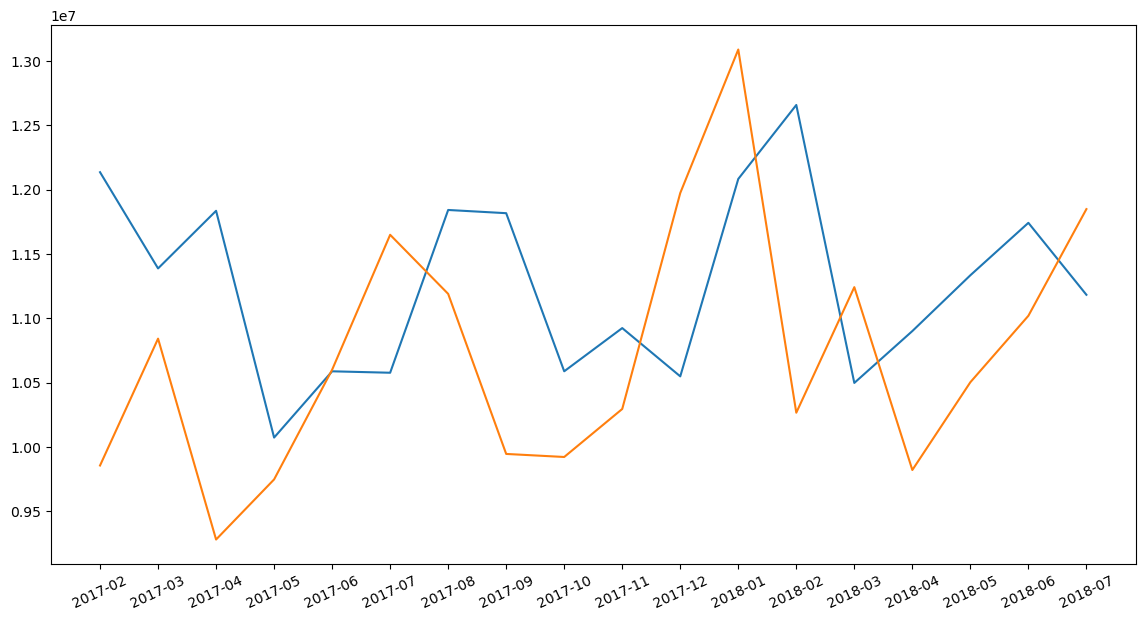

In [6]:

plt.figure(figsize=(14, 7))
plt.plot([date[:7] for date in dates[-len(preds):]],preds)
plt.plot([date[:7] for date in dates[-len(preds):]],test)
plt.xticks(rotation = 25)
plt.show()

In [ ]:
scores_df=pd.read_csv('scores.csv',index_col=[0])#['rmse']/1_000_000
scores_df.loc['RandomForest']=rmse/1_000_000
scores_df.sort_values('rmse_per_million').to_csv('scores.csv')

# XGBoost and LGBM

# Using this reference.
https://www.analyticsvidhya.com/blog/2024/01/xgboost-for-time-series-forecasting/

In [8]:
#creating lags aka look_back

def create_lag_features(data,target,lag_steps=1):
    for i in range(1,lag_steps+1):
        data[f'lag_{i}']=data[target].shift(i)

    return data
    
def create_rolling_mean(data,target,window_size=3):
    data['rolling_mean']=data[target].rolling(window=window_size).mean()
    return data
#fourier transform

def apply_fourier_transform(data,target):
    values=data[target].values
    fourier_transform=fft(values)
    data['fourier_transform']=np.abs(fourier_transform)
    return data


In [9]:
data=create_lag_features(month_df,'energy',2)
data=create_rolling_mean(data,'energy')
data=apply_fourier_transform(data,'energy')
data=data.dropna()

In [10]:
train,test = my_own_train_test_split(data,19)
X_train=train.drop('energy',axis=1)
y_train=train['energy'].values
X_test=test.drop('energy',axis=1)
y_test=test.energy.values

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit
cv_split=TimeSeriesSplit(n_splits=3)
param_grid = {

    'learning_rate': [0.01, 0.1, 0.2],

    'max_depth': [3, 5, 7],

    'subsample': [0.8, 0.9, 1.0]

}

grid_search = GridSearchCV(xgb.XGBRegressor(), param_grid, cv=cv_split)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

In [12]:
model=xgb.XGBRegressor(**best_params)
model.fit(X_train, y_train)
preds_xg=model.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,preds_xg))

print('Test Score: %.2f RMSE' % (rmse))


Test Score: 434517.40 RMSE


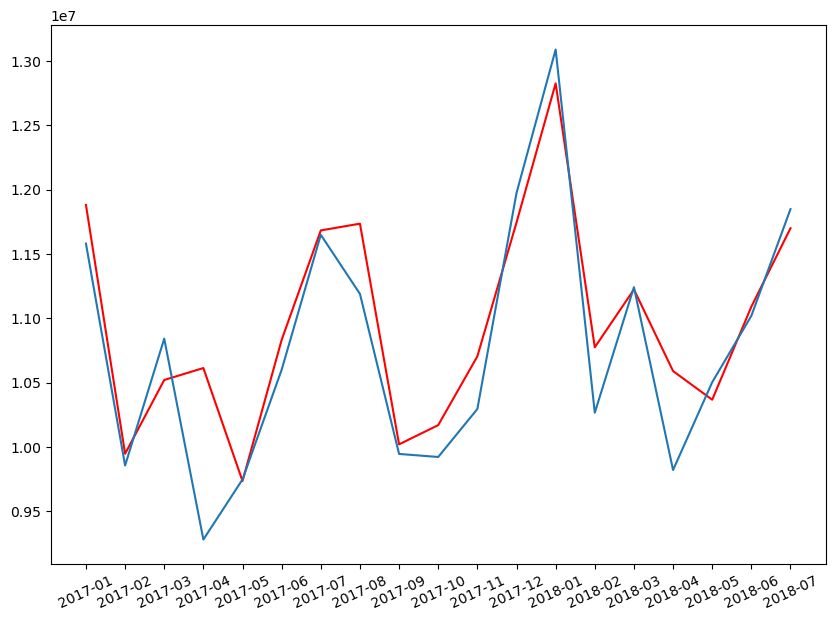

In [13]:
plt.figure(figsize=(10, 7))
plt.plot([date[:7] for date in dates[-len(preds_xg):]],preds_xg, c='r')
plt.plot([date[:7] for date in dates[-len(preds_xg):]],y_test)
plt.xticks(rotation = 25)
plt.show()

In [14]:
scores=pd.read_csv('scores.csv',index_col=[0])
scores.loc['XGboost']=rmse/1_000_000
scores.sort_values('rmse_per_million').to_csv('scores.csv')

In [15]:
from sklearn.model_selection import RandomizedSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = [1, 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
grid_search = RandomizedSearchCV(RandomForestRegressor(), random_grid, cv=cv_split)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_


In [16]:
rf=RandomForestRegressor(**best_params)
rf.fit(X_train, y_train)
preds_rf=rf.predict(X_test)

rmse=np.sqrt(mean_squared_error(y_test,preds_rf))

print('Test Score: %.2f RMSE' % (rmse))


Test Score: 631570.00 RMSE


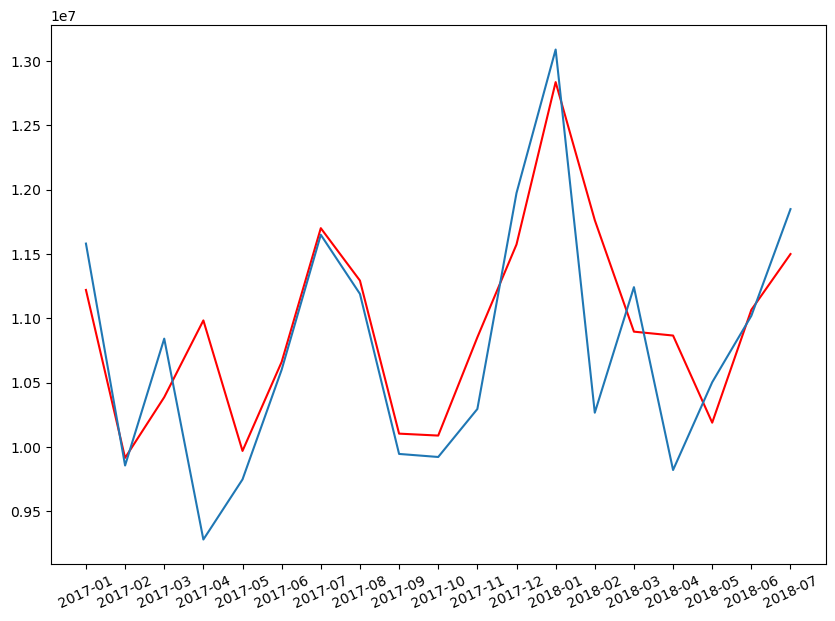

In [17]:
plt.figure(figsize=(10, 7))
plt.plot([date[:7] for date in dates[-len(preds_rf):]],preds_rf, c='red')
plt.plot([date[:7] for date in dates[-len(preds_rf):]],y_test)
plt.xticks(rotation = 25)
plt.show()

In [18]:
scores=pd.read_csv('scores.csv',index_col=[0])
scores.loc['RandomForest']=rmse/1_000_000
scores.sort_values('rmse_per_million').to_csv('scores.csv')

In [1]:
from lightgbm import lgb

ModuleNotFoundError: No module named 'lightgbm'

## using Memory between batches or (stateful)

In [ ]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True))  #We add stateful as True as we remember the previuos state
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2,validation_data=(testX, testY),shuffle=False)
    #model.reset_state()

In [ ]:
# make predictions
trainPredict = model.predict(trainX, batch_size=batch_size)
testPredict = model.predict(testX,batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

## Stacked LSTMs with Memory Between Batches

In [ ]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
#reshaping the arrays
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 

batch_size=1

model = Sequential()
model.add(Input(batch_shape=(batch_size,look_back,1)))
model.add(LSTM(4,stateful=True,return_sequences=True))
model.add(LSTM(4,stateful=True))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
for i in range(100):
    my_model=model.fit(trainX, trainY, epochs=1, batch_size=batch_size, verbose=2,validation_data=(testX, testY),shuffle=False)
    #model.reset_states()

In [ ]:
trainPredict = model.predict(trainX, batch_size=batch_size)
#model.reset_states()
testPredict = model.predict(testX, batch_size=batch_size)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

# MORE THINGS WITH LSTM
Combining things that work the best not to get the best forecast

In [ ]:
look_back=3
trainX, trainY =create_dataset(train,look_back)
testX,testY =create_dataset(test,look_back)
trainX = np.reshape(trainX,(trainX.shape[0],trainX.shape[1],1))
print(trainX.shape)
testX = np.reshape(testX,(testX.shape[0],testX.shape[1],1)) 
model=Sequential()
model.add(Input(shape=(trainX.shape[1],1)))
model.add(LSTM(units=20, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=10, return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')
my_model=model.fit(trainX, trainY, epochs=50,batch_size=32,verbose=2,validation_data=(testX, testY))

In [ ]:
trainPredict = model.predict(trainX)
#model.reset_states()
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict[:,0])
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict[:,0])
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
if testScore<best_score:
    best_score=testScore
    print('We have a new winner:', '{:_}'.format(round(testScore)))
else:
    print('Nothing changed')

In [ ]:
results=pd.read_csv('scores.csv',index_col=0)
results.loc['LSTM']=best_score
results.sort_values('rmse').to_csv('scores.csv')
##LSTM got the thirsd position
results.sort_values('rmse')